# Assignment #2
## 1 Data Cleaning

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import itertools
import seaborn as sns

%matplotlib inline

**#Task #1 [5%]:** Load the campusDemand.csv, keeping only the columns of “Point name”, “Time” and “Value”.

In [5]:
f = open('data/campusDemand.csv')
cols=['Point name','Time','Value'] #select used cols
data = pd.read_csv(f,usecols=cols,sep=',', header='infer', parse_dates=[1])
data['Value']=data['Value']/1000 #convert into kW
data.head()

,Point name,Time,Value
0,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:00:50,80.635422
1,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:01:50,77.046992
2,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:02:50,76.787828
3,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:03:50,79.804031
4,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:04:50,79.397078


**Task #2 [5%]:** Remove all meters except for Porter Hall and Baker Hall from the loaded dataset.

In [7]:
pointNames = data['Point name'].unique()[:2] #first two
pd.DataFrame([(pn, len(data[data['Point name'] == pn])) for pn in pointNames],
            columns=['Point name','Number of samples'])

,Point name,Number of samples
0,Porter Hall Electric (Shark 30) - Watts,86381
1,Baker Hall Electric (Shark 29) - Watts,10342


In [8]:
df1=data[data['Point name'] == pointNames[0]]
df2=data[data['Point name'] == pointNames[1]]
data=pd.concat([df1, df2], ignore_index=True)
data.head()

,Point name,Time,Value
0,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:00:50,80.635422
1,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:01:50,77.046992
2,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:02:50,76.787828
3,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:03:50,79.804031
4,Porter Hall Electric (Shark 30) - Watts,2014-09-10 00:04:50,79.397078


**Task #3 [5%]:** *Identify and remedy* at least two examples of these problems in the dataset.

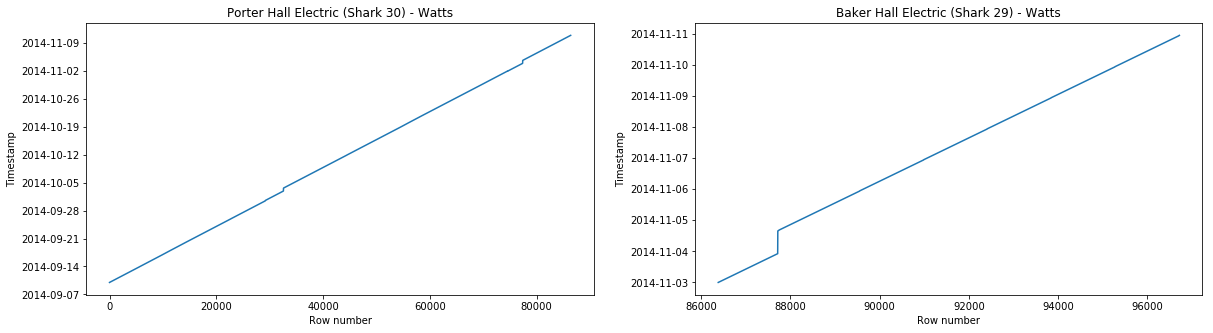

In [9]:
fig = plt.figure(figsize=(20,5))
for meter,i in zip(pointNames,range(len(pointNames))):
    plt.subplot(1,2,i+1)
    plt.plot(data[data['Point name']==meter]['Time'])
    plt.title(meter)
    plt.xlabel('Row number')
    plt.ylabel('Timestamp')

In [10]:
idx = [np.where(data['Point name']==meter) for meter in pointNames]
delta_t = [[d/np.timedelta64(1, 'D') for d in np.diff(data['Time'].iloc[i[0]])] for i in idx]

np.set_printoptions(threshold=np.nan)
for i in range(len(delta_t)):
    resolution = np.median(delta_t[i]) # use median as the resolution
    gap_idx = np.where(np.array(delta_t[i]) > (resolution)) # define the gap to be the delta_t> resolution
    # print out the gap for each power meter
    print("-=-=-=-=-=-=-=-=-\n{}\nresolution:{}\ngaps:".format(pointNames[i],resolution))
np.set_printoptions(threshold=8)

-=-=-=-=-=-=-=-=-
Porter Hall Electric (Shark 30) - Watts
resolution:0.0006944444444444445
gaps:
-=-=-=-=-=-=-=-=-
Baker Hall Electric (Shark 29) - Watts
resolution:0.0006944444444444445
gaps:


**Task #4 [10%]:** Following the same normalization approach documented in Kwac et al. (i.e., Equation 1 from paper #1), create daily load curves for meters Porter Hall and Baker Hall (you can store these however you like, but you should be able to recover what meter each
load curve came from).

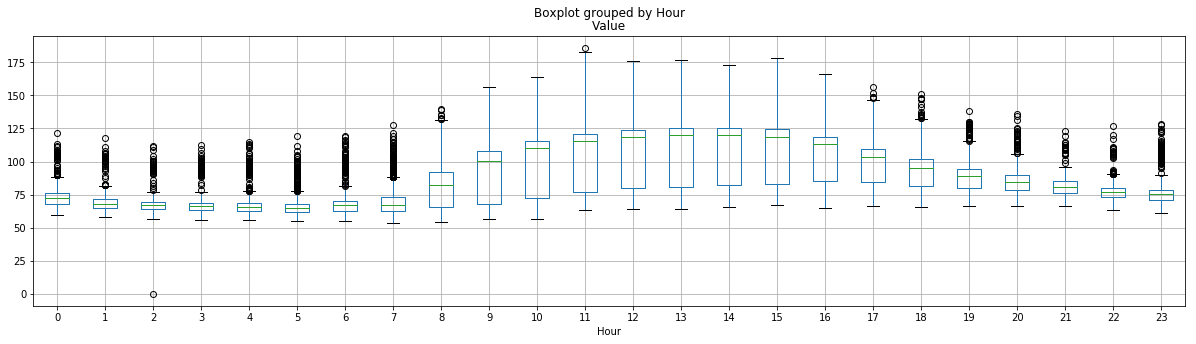

In [16]:
data['Hour'] = data['Time'].dt.hour
data['DayOfYear'] = data['Time'].dt.dayofyear
df1=data[data['Point name'] == pointNames[0]]
df2=data[data['Point name'] == pointNames[1]]
df1.boxplot(by="Hour",column=['Value'],figsize=(20,5))

In [12]:
#load Curves
loadCurves = data.groupby(['DayOfYear', 'Hour'])['Value'].mean().unstack()
loadCurves = loadCurves.replace(np.inf, np.nan).fillna(0)

#load curves for 1.Porter Hall and 2.Baker Hall 
lc1=df1.groupby(['DayOfYear', 'Hour'])['Value'].mean().unstack()
lc2=df2.groupby(['DayOfYear', 'Hour'])['Value'].mean().unstack()
#replace na with 0.1
lc1=lc1.replace(np.inf, np.nan).fillna(0)
lc2=lc2.replace(np.inf, np.nan).fillna(0)
lc2

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DayOfYear,,,,,,,,,,,,,,,,,,,,,
307,175.852930,175.942917,176.160844,174.275443,174.106853,174.261518,169.094900,177.682604,213.738464,240.834234,...,285.848431,282.179261,265.808264,234.853047,216.433591,201.523218,195.322661,192.279532,184.430220,0.000000
308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,286.586233,265.938267,239.585123,222.697812,209.463517,197.027155,186.071296,181.531721,178.805078
309,180.193163,182.560160,183.842780,179.764531,182.836855,175.745066,176.432762,180.821283,212.186652,251.332272,...,291.658874,285.164083,272.461321,237.702088,219.649703,206.454560,202.381737,193.751685,185.432286,183.448285
310,186.157468,183.998117,181.802408,182.144195,183.023390,177.470083,176.171268,186.631749,224.335634,257.182840,...,301.060032,294.788286,276.780736,246.844796,224.904487,208.292501,201.058415,195.169069,187.074535,188.150353
311,188.400620,182.542287,179.710584,177.053361,180.046761,174.740786,176.120018,188.299121,217.889758,241.979390,...,277.692398,269.128969,246.022263,221.403711,205.581470,194.892612,188.247514,185.002102,182.339011,181.330262
312,181.016096,176.967548,173.808963,170.832941,172.258333,171.131140,171.988145,167.823309,171.800550,182.450307,...,187.203922,178.987205,176.308873,176.490823,176.148830,177.432243,176.202477,176.172438,177.231555,178.389350
313,176.348750,174.001091,177.574199,173.242941,173.765359,173.051066,173.211362,171.852120,170.873375,173.944022,...,179.469293,181.268515,184.402566,188.127345,189.121753,188.820933,186.481231,185.176643,184.925333,180.496314
314,178.477067,170.902829,168.781275,168.183836,170.888739,167.238539,168.414832,177.146661,216.465390,251.176082,...,291.936339,288.816652,272.834723,236.619500,215.968310,201.579994,192.943178,186.367610,180.377802,0.000000


In [13]:
#Normalized
X1 = lc1.as_matrix().astype(np.float32)
X2 = lc2.as_matrix().astype(np.float32)
#normalize s(t) = l(t)/a
X1 = (X1.T /X1.sum(axis=1)).T 
X2 = (X2.T /X2.sum(axis=1)).T 
#convert to dataFrame
X1 = pd.DataFrame(X1)
X2 = pd.DataFrame(X2)
X2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.034993,0.035011,0.035054,0.034679,0.034645,0.034676,0.033648,0.035357,0.042532,0.047923,...,0.056881,0.056150,0.052893,0.046733,0.043068,0.040101,0.038867,0.038261,0.036700,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.145645,0.135151,0.121759,0.113176,0.106451,0.100130,0.094563,0.092256,0.090870
2,0.033835,0.034280,0.034521,0.033755,0.034332,0.033000,0.033129,0.033953,0.039843,0.047193,...,0.054766,0.053546,0.051161,0.044634,0.041244,0.038767,0.038002,0.036381,0.034819,0.034447
3,0.034299,0.033901,0.033497,0.033560,0.033722,0.032698,0.032459,0.034386,0.041333,0.047385,...,0.055469,0.054314,0.050996,0.045480,0.041438,0.038377,0.037044,0.035959,0.034468,0.034666
4,0.036581,0.035444,0.034894,0.034378,0.034959,0.033929,0.034197,0.036562,0.042307,0.046985,...,0.053919,0.052256,0.047770,0.042989,0.039917,0.037842,0.036552,0.035921,0.035404,0.035208
5,0.042383,0.041435,0.040695,0.039998,0.040332,0.040068,0.040269,0.039294,0.040225,0.042718,...,0.043831,0.041908,0.041281,0.041323,0.041243,0.041544,0.041256,0.041249,0.041497,0.041768
6,0.041138,0.040590,0.041424,0.040413,0.040535,0.040368,0.040406,0.040089,0.039860,0.040577,...,0.041866,0.042285,0.043016,0.043885,0.044117,0.044047,0.043501,0.043197,0.043138,0.042105
7,0.035513,0.034006,0.033584,0.033465,0.034003,0.033277,0.033511,0.035249,0.043072,0.049979,...,0.058089,0.057469,0.054288,0.047082,0.042973,0.040110,0.038392,0.037083,0.035891,0.000000


## 2 Exploratory Data Analysis

**Task #5 [10%]:** Using data from Porter Hall and Baker Hall, recreate Figure 2 from Kwac et al. (Zone 3 and Zone 13 from the paper would correspond to the two meters).

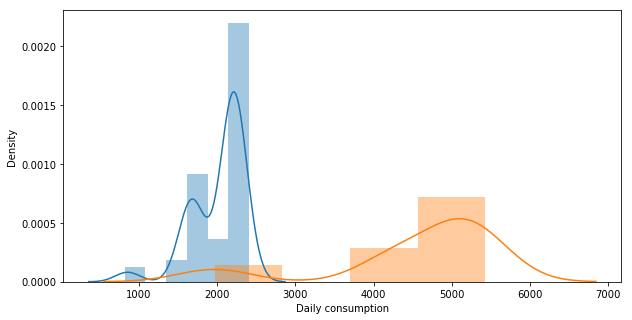

In [35]:
# daily consumption -- sum of hourly avg kw
daily1 = lc1.sum(axis=1)
daily2 = lc2.sum(axis=1)
# draw
plt.figure(figsize=(10,5))
plt.xlabel('Daily consumption')
plt.ylabel('Density')

sns.distplot(daily1, kde_kws=dict(cumulative=0), label='1.Porter Hall') # hist_kws=dict(cumulative=True)
sns.distplot(daily2, kde_kws=dict(cumulative=0),label='2.Baker Hall')

**Task #6 [10%]:** Plot the empirical Cumulative Distribution Function (CDF) of the densities you showed in the previous task

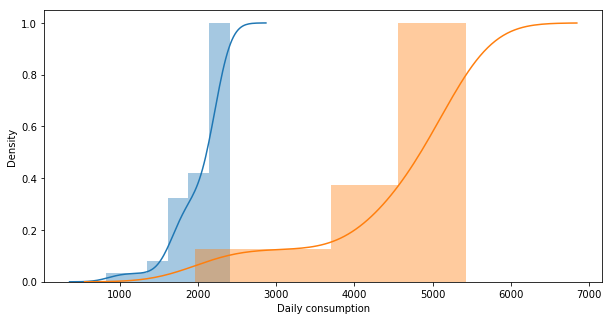

In [37]:
# draw
plt.figure(figsize=(10,5))
plt.xlabel('Daily consumption')
plt.ylabel('Density')

sns.distplot(daily1, kde_kws=dict(cumulative=True),hist_kws=dict(cumulative=True), label='1.Porter Hall') # hist_kws=dict(cumulative=True)
sns.distplot(daily2, kde_kws=dict(cumulative=True),hist_kws=dict(cumulative=True),label='2.Baker Hall')

**Task #7 [5%]:** Comment on what you have learned from the CDF and PDF plots that were generated for Porter Hall and Baker Hall.

**Task #8 [5%]:** If you were asked to suggest a probability distribution for this daily consumption data, which one would you suggest? Please provide some evidence for your claim.

**Task #9 [5%]:** Create two figures (one for each meter), containing seven box plots corresponding to the daily consumption for the seven days of the week.

**Task #10 [5%]:** Repeat the same process but now with Violin plots (see e.g.,seaborn.violinplot())

## 3 Clustering

**Task #11 [5%]:** Create one single figure showing line plots for all of the load curves for both meters. This plot should have, on the horizontal axis, the hours of the day 

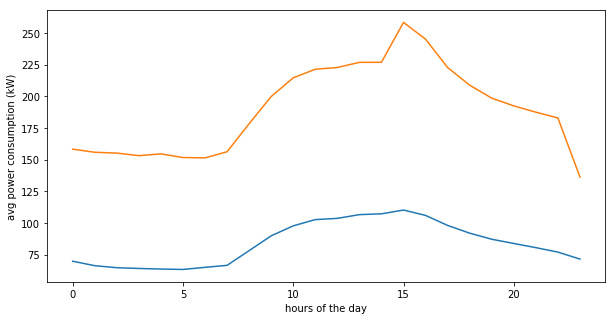

In [49]:
# draw
plt.figure(figsize=(10,5))
plt.xlabel('hours of the day')
plt.ylabel('avg power consumption (kW)')

plt.plot(np.mean(lc1,axis=0), label='1.Porter Hall')
plt.plot(np.mean(lc2,axis=0), label='2.Baker Hall')

**Task #12 [5%]:** Re-generate the figure by having load curves from Porter Hall show as light green, and curves from Baker Hall show as light red (think Christmas). Finish it by including in it an average load curve for each of the meters (i.e., the average hourly demand for all of the days recorded by the meter). Plot this average load curve in dark green (for Porter Hall) and
dark red (Baker Hall).

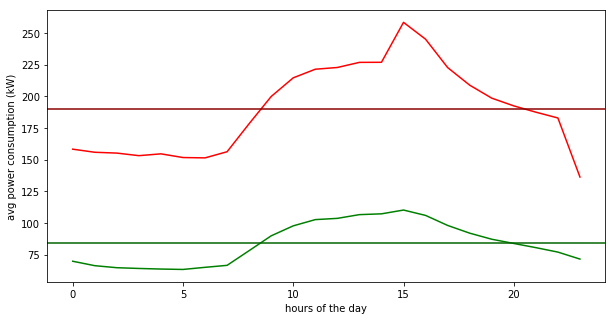

In [70]:
# draw
plt.figure(figsize=(10,5))
plt.xlabel('hours of the day')
plt.ylabel('avg power consumption (kW)')

plt.plot(np.mean(lc1,axis=0),c='green', label='1.Porter Hall')
plt.plot(np.mean(lc2,axis=0),c='red', label='2.Baker Hall')
plt.axhline(y=np.mean(lc1).mean(),c='darkgreen',label='1.Porter Hall mean')
plt.axhline(y=np.mean(lc2).mean(),c='darkred',label='2.Baker Hall mean')

**Task #13 [5%]:** What did you learn from this? Are there some clear clusters of 24dimensional vectors? Is this a useful way of thinking about clsuters of the data? Did any particular load curve stand out to you? If so, did you check what day it came from and what
the causes for it may be?

**Task #14 [5%]:** Compute the total scatter for the entire load curve dataset (i.e., both meters). For this task, and the following two, use the Euclidean distance as the dissimilarity
measure.

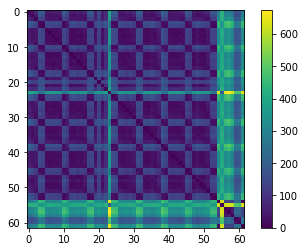

In [74]:
import scipy.spatial.distance as dist
D = dist.squareform(dist.pdist(loadCurves),'euclidean') #Euclidean distance
T = lambda D: np.sum(np.sum(D)) # total scatter

plt.imshow(D)
plt.colorbar()

As you now know, this total scatter can be decomposed in to a “within” cluster scatter (i.e., W(C)) and a betwee-cluster scatter (B(C)) for any cluster assignment C. Since we know the data came from two separate buildings, it would make sense to ask what is the W(C) and B(C) for this dataset too, assuming that there are two clusters and the assignment is done by just assigning
each load curve to the meter from which it came from.

**Task #15 [5%]:** Calculate W(C) and B(C) as stated above.

**Task #16 [5%]:** Create three random cluster assignment Ci with i ∈ 3, 5 and 10 clusters. Recompute T for each one of these cluster assignments, by computing Ti = W(Ci)+B(Ci). Are
they all the same?

**Task #17 [10%]:** Using the sci-kit learn k-Means implementation, perform clustering on the load curve dataset (combining data from Porter Hall and Baker Hall). Specifically, see if you can find cluster assignments that separate the load curves from both meters. Then see if you can apply a transformation to the load curve dataset to allow for clusters that are not based on the meters but rather on temporal patterns (i.e., different times of the year, different days
of the week, etc).

In [2]:
!git status
!git add Assignment#2.ipynb
!git commit -m "hw2"
!git push

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Hello.ipynb
	modified:   IW_Energy.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.ipynb_checkpoints/
	Assignment#2.ipynb
	data/

no changes added to commit (use "git add" and/or "git commit -a")


The file will have its original line endings in your working directory.
